## Installing missing libraries to Colab

In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install wget
!pip install optuna
!pip install wandb


In [ ]:
# import torch
# print(torch.__version__)

1.13.1+cu116


## Loading libraries

In [ ]:
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
import collections


import tensorflow as tf
import torch
from torch.utils.data import DataLoader


import transformers
from transformers import BertTokenizer, AutoTokenizer, AutoModelForMaskedLM
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import TrainingArguments
from transformers import pipeline


import evaluate
from evaluate import evaluator


from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import datasets
from datasets import load_dataset
from datasets import Dataset

from textblob import TextBlob
import nltk


import wandb


import re
import os
import wget
import glob

In [ ]:
# for the Naive Bayes Classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

Helper Functions

In [ ]:
# source: https://gist.github.com/hantoine/c4fc70b32c2d163f604a8dc2a050d5f6

from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)



def word_count(sentence):
    n_words = len(sentence.split())
    return n_words



def tokenizer_length(input_sentence):
  length_of_input = len(tokenizer.encode(input_sentence,add_special_tokens=True))
  return length_of_input

## Initializing GPU utilization and reporting to Weights and Biases Dashboard

GPU

In [ ]:
# source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

# code to see what GPU is assigned by Google colab and to utilize it for calculations

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


# check for GPU availability
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


W and B reporting & Google Drive Connection

In [ ]:
# requires for the wandb website to be running and logged in with profile
# requires an account on wandb.ai

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# connecting to the google drive where models and data are stored

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading the corresponding pre-trained BERT model from huggingface

Name of the current model in use

In [ ]:
# bert base uncased:                          bert-base-uncased
# bert base cased:                            -
# climateBERT pre-trained on entire dataset:  climatebert/distilroberta-base-climate-f 
# climateBERT pre-trained on envir. claims:   climatebert/environmental-claims
# distilroberta base:                         distilroberta-base
# RoBERTa base:                               roberta-base

# BERTweet:                                   vinai/bertweet-base


# paste the corresponding model directory name into the model_checkpoint string

model_checkpoint = "climatebert/distilroberta-base-climate-f"

In [ ]:
# main source: https://huggingface.co/docs/transformers/v4.24.0/en/training

# loading this model loads the pre-trained version into the GPU memory,
# training steps after this will adjust the weights of the model and thus
# fine tune it.

# to reload the model from scratch, execute this command below again


# num_labels = 2 ensures that we have a classifier for a binary classification

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                           num_labels=2)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Define the tokenizer, training arguments and metrics

In [ ]:
# Source (with own modifications): 
# https://huggingface.co/docs/transformers/main_classes/tokenizer?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/#3-tokenization--input-formatting
# https://towardsdatascience.com/how-to-apply-transformers-to-any-length-of-text-a5601410af7f

# importance of padding & truncating within Tokenizer: 
# BERT input (e.g. the tokenized sentences need to be uniform) --> use padding within the tokenizer
# use truncate to truncate sentences that are too long

# output should be in a format that can be used by the model (e.g. PyTorch Tensors)
# thus we need to set return_tensors = 'pt' for PyTorch Tensors

# https://huggingface.co/docs/datasets/process#map
# use .map function from huggingface's datasets to apply a function to an
# entire dataset (only works if it is in the Dataset format)

# potentially a longer max length is required for the paragraphs

def tokenize_function(examples):
    return tokenizer(examples["sentence"], 
                        add_special_tokens = True,
                        max_length = 128,
                        padding="max_length", 
                        return_attention_mask = True,
                        truncation=True,
                        return_tensors = 'pt'
                        )
    

# ------------------------------------------------------------------------------
# training arguments
seed_number = 123456789
output_directory_name = "./BERT_training_output"


batch_size = 16

# to chose best performing model
metric_name = 'f1'



args = TrainingArguments(
    output_dir = output_directory_name,
    seed = seed_number,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",  # to decide when the model is saved
    learning_rate = 5e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 4,
    weight_decay = 0.01,
    load_best_model_at_end=True,
    metric_for_best_model = metric_name,
    push_to_hub = False,
    report_to="wandb",
)


# ------------------------------------------------------------------------------
# compute_metrics function



def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


## Importing the data

create new directories for the input data

In [ ]:
os.makedirs('./climaText/')
os.makedirs('./climate_tweets/')
os.makedirs('./analysis_data/')

climaText data (UZH website currently not working --> currently manual upload)

In [ ]:
# train data

wget.download('https://www.sustainablefinance.uzh.ch/dam/jcr:43546a2f-82d6-49a3-af54-69b02cff54a9/AL-10Ks.tsv%20:%203000%20(58%20positives,%202942%20negatives)%20(TSV,%20127138%20KB).tsv',
              out = './climaText')

wget.download('https://www.sustainablefinance.uzh.ch/dam/jcr:9d139a47-878c-4d2c-b9a7-cbb982e284b9/AL-Wiki%20(train).tsv',
              out = './climaText')


# dev data
wget.download('https://www.sustainablefinance.uzh.ch/dam/jcr:058aefdc-0c46-4a4b-8192-a4af095b8984/Wikipedia%20(dev).tsv',
              out = './climaText')


# test data
wget.download('https://www.sustainablefinance.uzh.ch/dam/jcr:8533e714-155f-49f2-b997-6b9873749303/Wikipedia%20(test).tsv',
              out = './climaText')

wget.download('https://www.sustainablefinance.uzh.ch/dam/jcr:d5e1ac74-0bf1-4d84-910f-7a9c7cd28764/Claims%20(test).tsv',
              out = './climaText')

wget.download('https://www.sustainablefinance.uzh.ch/dam/jcr:cf6dea3a-ca4f-422f-8f1c-e90d88dd56dd/10-Ks%20(2018,%20test).tsv',
              out = './climaText')


'./climaText/10-Ks (2018, test).tsv'

In [ ]:
# loading the climaText datasets to dataframes

# training data
data_climaText_ALWiki_train = pd.read_csv("./climaText/AL-Wiki (train).tsv", sep = '\t')
# data_climaText_AL10K_train = pd.read_csv('./climaText/AL-10Ks.tsv : 3000 (58 positives, 2942 negatives) (TSV, 127138 KB).tsv', sep = '\t')
data_climaText_AL10K_train = pd.read_csv('./climaText/AL-10Ks.tsv : 3000 (58 positives, 2942 negatives) (TSV, 127138 KB).tsv', sep = '\t')

# dev data
data_climaText_Wiki_dev = pd.read_csv("./climaText/Wikipedia (dev).tsv", sep = '\t')

# testing data
data_climaText_Wiki_test = pd.read_csv("./climaText/Wikipedia (test).tsv", sep = '\t')
data_climaText_claims_test = pd.read_csv("./climaText/Claims (test).tsv", sep = '\t')
data_climaText_10K_test = pd.read_csv("./climaText/10-Ks (2018, test).tsv", sep = '\t')



In [ ]:
# converting to datasets

# training data
dataset_climaText_ALWiki_train = Dataset.from_pandas(data_climaText_ALWiki_train)
dataset_climaText_AL10K_train = Dataset.from_pandas(data_climaText_AL10K_train)

# dev data
dataset_climaText_Wiki_dev = Dataset.from_pandas(data_climaText_Wiki_dev)

# testing data
dataset_climaText_Wiki_test = Dataset.from_pandas(data_climaText_Wiki_test)
dataset_climaText_claims_test = Dataset.from_pandas(data_climaText_claims_test)
dataset_climaText_10K_test = Dataset.from_pandas(data_climaText_10K_test)

In [ ]:
# tokenizing the datasets:

# training data
tok_dataset_climaText_ALWiki_train = dataset_climaText_ALWiki_train.map(tokenize_function, batched = True)
tok_dataset_climaText_AL10K_train = dataset_climaText_AL10K_train.map(tokenize_function, batched = True)
 
# dev data
tok_dataset_climaText_Wiki_dev = dataset_climaText_Wiki_dev.map(tokenize_function, batched = True)

# testing data
tok_dataset_climaText_Wiki_test = dataset_climaText_Wiki_test.map(tokenize_function, batched = True)
tok_dataset_climaText_claims_test = dataset_climaText_claims_test.map(tokenize_function, batched = True)
tok_dataset_climaText_10K_test = dataset_climaText_10K_test.map(tokenize_function, batched = True)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

politicians data

In [ ]:
data_politicians = pd.read_csv('/content/gdrive/MyDrive/analysis_data/politicians_for_analysis_dataset.csv')
dataset_politicians = Dataset.from_pandas(data_politicians) 

In [ ]:
# data_politicians = pd.read_csv('./analysis_data/politicians_for_analysis_dataset.csv')
# dataset_politicians = Dataset.from_pandas(data_politicians) 

## climaText training and evaluation loop

In [ ]:

def tokenize_function_tweets(examples):
    return tokenizer(examples["sentence"], 
                        add_special_tokens = True,
                        max_length = 512,
                        padding="max_length", 
                        return_attention_mask = True,
                        truncation=True,
                        return_tensors = 'pt'
                        )
    

# ------------------------------------------------------------------------------
# training arguments
seed_number = 123456789
output_directory_name = "./climate_classifier_training_output"


batch_size = 16

# to chose best performing model
metric_name = 'f1'



args = TrainingArguments(
    output_dir = output_directory_name,
    seed = seed_number,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",  # to decide when the model is saved
    learning_rate = 5e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 4,
    weight_decay = 0.01,
    load_best_model_at_end=True,
    metric_for_best_model = metric_name,
    push_to_hub = False,
    report_to="wandb",
)


# ------------------------------------------------------------------------------
# compute_metrics function



def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# as in climaText (2020) the model is first trained on AL wiki data
# the model is evaluated on the wiki dev dataset in both runs
# the model is tested on the claims AL test set

directory_to_save_first_run = "./climaText_finetuning/run_1"
directory_to_save_second_run = "./climaText_finetuning/run_2"


trainer_climaText = Trainer(
    model,
    args,
    train_dataset = tok_dataset_climaText_ALWiki_train,
    eval_dataset = tok_dataset_climaText_Wiki_dev,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics ##,
    ## optimizer = ""
)

In [ ]:
# training the model
# https://towardsdatascience.com/transformers-retraining-roberta-base-using-the-roberta-mlm-procedure-7422160d5764

# ------------------------------------------------------------------------------
# first run

# initialize wandb monitoring under project file name
wandb.init(project = "climaText"
           )

trainer_climaText.train()

# terminate the monitoring
wandb.finish()

trainer_climaText.save_model(directory_to_save_first_run)

climaText_pipe_first_run = pipeline("text-classification", model = directory_to_save_first_run, device=0)

metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

task_evaluator_first_run = evaluator("text-classification")

# check case for climate BERT claims (predicted labels are yes / no) -> use if statement
results_first_run = task_evaluator_first_run.compute(model_or_pipeline=climaText_pipe_first_run, 
                                                      data=dataset_climaText_claims_test, 
                                                      metric=metric,
                                                      input_column="sentence",
                                                      label_column="label",
                                                      label_mapping={"LABEL_0": 0, "LABEL_1": 1},
                                                      strategy="bootstrap",
                                                      n_resamples=10
                                                     )

print(results_first_run)

wandb: Currently logged in as: lhemmi. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.558070,0.843333,0.605042,0.972973,0.439024
2,No log,0.719083,0.846667,0.610169,1.000000,0.439024
3,0.134200,1.013821,0.840000,0.586207,1.000000,0.414634
4,0.134200,1.137151,0.836667,0.573913,1.000000,0.402439


eval/accuracy,▆█▃▁
eval/f1,▇█▃▁
eval/loss,▁▃▇█
eval/precision,▁███
eval/recall,██▃▁
eval/runtime,█▂▂▁
eval/samples_per_second,▁▇▇█
eval/steps_per_second,▁▇▇█
train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/learning_rate,▁


{'accuracy': {'confidence_interval': (0.7347042473727359, 0.7692883080413587), 'standard_error': 0.011452316602135823, 'score': 0.747}, 'f1': {'confidence_interval': (0.6229518998489797, 0.6882490400375155), 'standard_error': 0.02252419307673729, 'score': 0.6631158455392809}, 'precision': {'confidence_interval': (0.98490749656135, 0.9992835706441016), 'standard_error': 0.005239136064707638, 'score': 0.9920318725099602}, 'recall': {'confidence_interval': (0.4500066390479948, 0.519566533480641), 'standard_error': 0.025617851441040305, 'score': 0.498}, 'total_time_in_seconds': 6.957856817999982, 'samples_per_second': 143.72241714043312, 'latency_in_seconds': 0.006957856817999981}


In [ ]:
# ------------------------------------------------------------------------------
# second run

climaText_model_second_run = AutoModelForSequenceClassification.from_pretrained(directory_to_save_first_run)
climaText_tokenizer_second_run = AutoTokenizer.from_pretrained(directory_to_save_first_run)


trainer_climaText_second_run = Trainer(
    climaText_model_second_run,
    args,
    train_dataset = tok_dataset_climaText_AL10K_train,
    eval_dataset = tok_dataset_climaText_Wiki_dev,
    tokenizer = climaText_tokenizer_second_run,
    compute_metrics = compute_metrics ##,
    ## optimizer = ""
)


wandb.init(project = "climaText")

trainer_climaText_second_run.train()

wandb.finish()

trainer_climaText_second_run.save_model(directory_to_save_second_run)


climaText_pipe_second_run = pipeline("text-classification", model = directory_to_save_second_run, device=0)

task_evaluator_second_run = evaluator("text-classification")
results_second_run = task_evaluator_second_run.compute(model_or_pipeline=climaText_pipe_second_run, 
                                                        data=dataset_climaText_claims_test, 
                                                        metric=metric,
                                                        input_column="sentence",
                                                        label_column="label",
                                                        label_mapping={"LABEL_0": 0, "LABEL_1": 1},
                                                        strategy="bootstrap",
                                                        n_resamples=10)



print(results_second_run)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.832554,0.876667,0.713178,0.978723,0.560976
2,No log,0.451554,0.900000,0.782609,0.964286,0.658537
3,0.025100,0.841129,0.876667,0.717557,0.959184,0.573171
4,0.025100,0.885224,0.876667,0.717557,0.959184,0.573171


eval/accuracy,▁█▁▁
eval/f1,▁█▁▁
eval/loss,▇▁▇█
eval/precision,█▃▁▁
eval/recall,▁█▂▂
eval/runtime,█▅▁▄
eval/samples_per_second,▁▄█▅
eval/steps_per_second,▁▄█▅
train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/learning_rate,▁


{'accuracy': {'confidence_interval': (0.7702008781885418, 0.8063295041087534), 'standard_error': 0.012064640713902567, 'score': 0.796}, 'f1': {'confidence_interval': (0.7261677775251322, 0.7849483823623182), 'standard_error': 0.01863708040360664, 'score': 0.7475247524752475}, 'precision': {'confidence_interval': (0.9632335739987301, 0.9856425134409355), 'standard_error': 0.008381717760039431, 'score': 0.9805194805194806}, 'recall': {'confidence_interval': (0.5846310664688842, 0.6271910193157408), 'standard_error': 0.01894086534956136, 'score': 0.604}, 'total_time_in_seconds': 6.989034465000032, 'samples_per_second': 143.08128039829253, 'latency_in_seconds': 0.006989034465000031}


In [ ]:
# save the final model to the gdrive for later access
# !cp -r './BERT_training_output/checkpoint-376' /content/gdrive/MyDrive/climaText_climateBERT_trained/

testing the model on hand labelled climate tweets

In [ ]:
climaText_climateBERT_trained = "/content/gdrive/MyDrive/climaText_climateBERT_trained"
#climate_tweets_BERTweet_trained = "/content/gdrive/MyDrive/climate_tweet_BERTweet/"

model = AutoModelForSequenceClassification.from_pretrained(climaText_climateBERT_trained, 
                                                           num_labels=2)

tokenizer = AutoTokenizer.from_pretrained(climaText_climateBERT_trained)

climate_tweet_pipe = pipeline("text-classification", model = climaText_climateBERT_trained, device=0)

{'accuracy': 0.9815, 'f1': 0.6021505376344085, 'precision': 0.717948717948718, 'recall': 0.5185185185185185, 'total_time_in_seconds': 15.609110677000444, 'samples_per_second': 128.13029783605415, 'latency_in_seconds': 0.007804555338500223}


<Axes: >

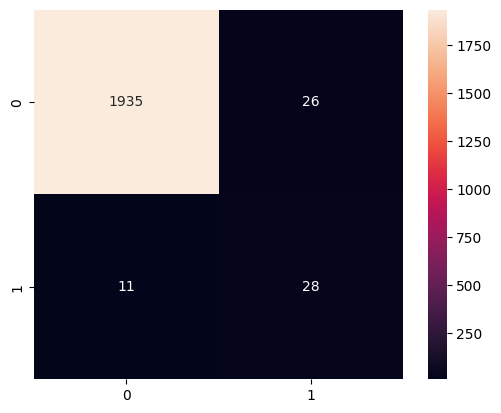

In [ ]:
golden_politician_tweets = pd.read_csv("/content/gdrive/MyDrive/analysis_data/labelled_golden_labels_dataset_politicians.csv", sep=";", encoding = "iso-8859-1")

golden_politician_tweets.rename(columns={'climate_related_human_labelled' : 'label', 'cleaned_text' : 'sentence'}, inplace = True)

dataset_golden_politician_tweets = Dataset.from_pandas(golden_politician_tweets)

metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

task_evaluator_first_run = evaluator("text-classification")

# check case for climate BERT claims (predicted labels are yes / no) -> use if statement
results_golden_label = task_evaluator_first_run.compute(model_or_pipeline=climate_tweet_pipe, 
                                                      data=dataset_golden_politician_tweets, 
                                                      metric=metric,
                                                      input_column="sentence",
                                                      label_column="label",
                                                      label_mapping={"LABEL_0": 0, "LABEL_1": 1} #,
                                                      # strategy="bootstrap",
                                                      # n_resamples=10
                                                     )

print(results_golden_label)


predictions_golden_labels = climate_tweet_pipe(dataset_golden_politician_tweets['sentence'], batch_size = 32)
golden_politician_tweets['full_prediction_climate'] = predictions_golden_labels

golden_politician_tweets['climate_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in golden_politician_tweets['full_prediction_climate']]

mat = confusion_matrix(golden_politician_tweets.label,golden_politician_tweets.climate_pred)
sns.heatmap(mat.T,square = True, annot=True, fmt = 'd')

## Inference on politicians data:

In [ ]:
climaText_climateBERT_trained = "/content/gdrive/MyDrive/climaText_climateBERT_trained"
#climate_tweets_BERTweet_trained = "/content/gdrive/MyDrive/climate_tweet_BERTweet/"

model = AutoModelForSequenceClassification.from_pretrained(climaText_climateBERT_trained, 
                                                           num_labels=2)

tokenizer = AutoTokenizer.from_pretrained(climaText_climateBERT_trained)

climate_tweet_pipe = pipeline("text-classification", model = climaText_climateBERT_trained, device=0)




In [ ]:
data_politicians['tok_length'] = data_politicians['cleaned_text'].apply(tokenizer_length)

In [ ]:
sum(data_politicians['tok_length'] >= 512)

0

In [ ]:
data_politicians_filtered = data_politicians

In [ ]:
# data_politicians_filtered = data_politicians[data_politicians['tok_length'] <= 128]
# data_politicians_filtered.reset_index(drop=True, inplace=True)

dataset_politicians_filtered = Dataset.from_pandas(data_politicians_filtered)
dataset_politicians_filtered[range(10)]['cleaned_text']

['FosterYouthVoices must be included in the child welfare reform discussion. Looking forward to hosting Alvin Guyton at DCShadowDay 2017.',
 'During Natl DrugCourtMonth, Id like to recognize the dedicated professionals who work in drug courts in Illinois. TY for all you do!',
 'The TrumpCuts budget is an assault on working families, our economy, and our security. The American people deserve better from the President. ',
 'Between TrumpCare and TrumpCuts, realDonaldTrump has turned his back on small towns and rural America. The broken promises are piling up. ',
 'Thank you RepBobbyRush for cosponsoring the ADA Edu and Reform Act HR620. We appreciate your leadership on this issue! thankyou ',
 'CBO confirms TrumpCare will: Leave millions uninsured Increase premiums Discriminate against people with pre-existing conditions ',
 'Police officer who fatally shot Tamir Rice fired after investigations find he broke rules when applying to the force ',
 "The President's decision to pull the U.S. 

In [ ]:
predictions_politician_tweets = climate_tweet_pipe(dataset_politicians_filtered['cleaned_text'], batch_size = 32)

In [ ]:
data_politicians_filtered['predictions']=predictions_politician_tweets

In [ ]:
data_politicians_filtered['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_politicians_filtered['predictions']]

In [ ]:
data_politicians_with_climate_pred = data_politicians_filtered.iloc[:,1:].copy()

In [ ]:
sum(data_politicians_with_climate_pred['climate_related_pred'] == 1)

6310

In [ ]:
data_politicians_with_climate_pred['year'].unique()

array([2017, 2018, 2019, 2021])

# inference on other datasets

loading the data

In [ ]:
exxon_data = pd.read_csv('/content/analysis_data/exxon_out.csv')
ipcc_data = pd.read_csv('/content/analysis_data/ipcc_out.csv')
downplaying_tweets_data = pd.read_csv('/content/analysis_data/downplaying_tweets_out.csv')
underscoring_tweets_data = pd.read_csv('/content/analysis_data/underscoring_tweets_out.csv')

exxon_data = exxon_data.dropna(subset=['cleaned_text'])
ipcc_data = ipcc_data.dropna(subset=['cleaned_text'])
downplaying_tweets_data = downplaying_tweets_data.dropna(subset=['cleaned_text'])
underscoring_tweets_data = underscoring_tweets_data.dropna(subset=['cleaned_text'])

exxon_data.reset_index(drop = True, inplace = True)
ipcc_data.reset_index(drop = True, inplace = True)
downplaying_tweets_data.reset_index(drop = True, inplace = True)
underscoring_tweets_data.reset_index(drop = True, inplace = True)





In [ ]:
climate_influencers_data = pd.read_csv('/content/gdrive/MyDrive/analysis_data/climate_influencers_tweets_out.csv')
climate_influencers_data = climate_influencers_data.dropna(subset=['cleaned_text'])
climate_influencers_data.reset_index(drop = True, inplace = True)

In [ ]:
selected_politicians_data = pd.read_parquet('/content/gdrive/MyDrive/analysis_data/selected_politicians_tweets.parquet')
selected_politicians_data = selected_politicians_data.dropna(subset=['cleaned_text'])
selected_politicians_data.reset_index(drop = True, inplace = True)

In [ ]:
greenpeace_data = pd.read_csv('/content/analysis_data/greenpeace_out.csv')
greenpeace_data = greenpeace_data.dropna(subset=['cleaned_text'])
greenpeace_data.reset_index(drop = True, inplace = True)

In [ ]:
greenpeace_API_tweets_data = pd.read_csv('/content/analysis_data/greenpeace_API_tweets_out.csv')
greenpeace_API_tweets_data = greenpeace_API_tweets_data.dropna(subset=['cleaned_text'])
greenpeace_API_tweets_data.reset_index(drop = True, inplace = True)

In [ ]:
politicians_with_trump_data = pd.read_csv('/content/analysis_data/politicians_tweets_with_trump_out.csv', encoding = 'UTF-8')
politicians_with_trump_data = politicians_with_trump_data.dropna(subset=['cleaned_text'])
politicians_with_trump_data.reset_index(drop = True, inplace = True)

In [ ]:
politicians_uk = pd.read_csv('/content/gdrive/MyDrive/analysis_data/politicians_for_analysis_dataset_uk.csv', encoding = 'UTF-8')
politicians_uk = politicians_uk.dropna(subset=['cleaned_text'])
politicians_uk.reset_index(drop = True, inplace = True)

In [ ]:
politicians_australia = pd.read_csv('/content/gdrive/MyDrive/analysis_data/politicians_for_analysis_dataset_australia.csv', encoding = 'UTF-8')
politicians_australia = politicians_australia.dropna(subset=['cleaned_text'])
politicians_australia.reset_index(drop = True, inplace = True)

get tok-length to filter sentences that are too long

In [ ]:
exxon_data['tok_length'] = exxon_data['cleaned_text'].apply(tokenizer_length)
ipcc_data['tok_length'] = ipcc_data['cleaned_text'].apply(tokenizer_length)
downplaying_tweets_data['tok_length'] = downplaying_tweets_data['cleaned_text'].apply(tokenizer_length)
underscoring_tweets_data['tok_length'] = underscoring_tweets_data['cleaned_text'].apply(tokenizer_length)
greenpeace_data['tok_length'] = greenpeace_data['cleaned_text'].apply(tokenizer_length)
greenpeace_API_tweets_data['tok_length'] = greenpeace_API_tweets_data['cleaned_text'].apply(tokenizer_length)
politicians_with_trump_data['tok_length'] = politicians_with_trump_data['cleaned_text'].apply(tokenizer_length)



Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
politicians_uk['tok_length'] = politicians_uk['cleaned_text'].apply(tokenizer_length)
politicians_australia['tok_length'] = politicians_australia['cleaned_text'].apply(tokenizer_length)

In [ ]:
climate_influencers_data['tok_length'] = climate_influencers_data['cleaned_text'].apply(tokenizer_length)

In [ ]:
selected_politicians_data['tok_length'] = selected_politicians_data['cleaned_text'].apply(tokenizer_length)

In [ ]:
sum(selected_politicians_data['tok_length'] > 512)

0

for data where the tok_length is longer than the supported 512, remove the long sentences from the dataset

In [ ]:
exxon_data_filtered = exxon_data[exxon_data['tok_length'].isin(range(3,513))].copy()
ipcc_data_filtered = ipcc_data[ipcc_data['tok_length'].isin(range(3,513))]
downplaying_tweets_data_filtered = downplaying_tweets_data[downplaying_tweets_data['tok_length'].isin(range(3,513))]
underscoring_tweets_data_filtered = underscoring_tweets_data[underscoring_tweets_data['tok_length'].isin(range(3,513))]


exxon_data_filtered.reset_index(drop=True, inplace=True)
ipcc_data_filtered.reset_index(drop=True, inplace=True)
downplaying_tweets_data_filtered.reset_index(drop=True, inplace=True)
underscoring_tweets_data_filtered.reset_index(drop=True, inplace=True)




converting to Dataset format required for the model input

In [ ]:
dataset_exxon_data = Dataset.from_pandas(exxon_data_filtered)
dataset_ipcc_data = Dataset.from_pandas(ipcc_data_filtered) 
dataset_downplaying_tweets_data = Dataset.from_pandas(downplaying_tweets_data_filtered)
dataset_underscoring_tweets_data = Dataset.from_pandas(underscoring_tweets_data_filtered)
dataset_greenpeace_data = Dataset.from_pandas(greenpeace_data)
dataset_greenpeace_API_tweets_data = Dataset.from_pandas(greenpeace_API_tweets_data)
dataset_politicians_with_trump_data = Dataset.from_pandas(politicians_with_trump_data)

In [ ]:
dataset_politicians_uk = Dataset.from_pandas(politicians_uk)
dataset_politicians_australia = Dataset.from_pandas(politicians_australia)

In [ ]:
dataset_climate_influencers_data = Dataset.from_pandas(climate_influencers_data)

In [ ]:
dataset_selected_politicians_data = Dataset.from_pandas(selected_politicians_data)

getting inference from the climate BERT model (within the pipe function)

In [ ]:
predictions_exxon = climate_tweet_pipe(dataset_exxon_data['cleaned_text'], batch_size = 32)
predictions_ipcc = climate_tweet_pipe(dataset_ipcc_data['cleaned_text'], batch_size = 32)
predictions_downplaying_tweets = climate_tweet_pipe(dataset_downplaying_tweets_data['cleaned_text'], batch_size = 32)
predictions_underscoring_tweets = climate_tweet_pipe(dataset_underscoring_tweets_data['cleaned_text'], batch_size = 32)
predictions_greenpeace = climate_tweet_pipe(dataset_greenpeace_data['cleaned_text'], batch_size = 32)
predictions_greenpeace_API = climate_tweet_pipe(dataset_greenpeace_API_tweets_data['cleaned_text'], batch_size = 32)
predictions_politicians_with_trump = climate_tweet_pipe(dataset_politicians_with_trump_data['cleaned_text'], batch_size = 32)

In [ ]:
predicitons_politicians_uk = climate_tweet_pipe(dataset_politicians_uk['cleaned_text'], batch_size = 32)
predicitons_politicians_australia = climate_tweet_pipe(dataset_politicians_australia['cleaned_text'], batch_size = 32)

In [ ]:
predictions_climate_influencers_data = climate_tweet_pipe(dataset_climate_influencers_data['cleaned_text'], batch_size = 32)

In [ ]:
predictions_selected_politicians_data = climate_tweet_pipe(dataset_selected_politicians_data['cleaned_text'], batch_size = 32)

assigning the climate-related predictions to the correct column

In [ ]:
exxon_data_filtered['predictions']=predictions_exxon
ipcc_data_filtered['predictions']=predictions_ipcc
downplaying_tweets_data_filtered['predictions']=predictions_downplaying_tweets
underscoring_tweets_data_filtered['predictions']=predictions_underscoring_tweets
greenpeace_data['predictions']=predictions_greenpeace
greenpeace_API_tweets_data['predictions']=predictions_greenpeace_API
politicians_with_trump_data['predictions']=predictions_politicians_with_trump


In [ ]:
politicians_uk['predictions'] = predicitons_politicians_uk
politicians_australia['predictions'] = predicitons_politicians_australia


In [ ]:
climate_influencers_data['predictions'] = predictions_climate_influencers_data

In [ ]:
selected_politicians_data['predictions'] = predictions_selected_politicians_data

changing the climate related labels to 0 and 1

In [ ]:
politicians_uk['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in politicians_uk['predictions']]
politicians_australia['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in politicians_australia['predictions']]

In [ ]:
climate_influencers_data['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in climate_influencers_data['predictions']]

In [ ]:
selected_politicians_data['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in selected_politicians_data['predictions']]

In [ ]:
politicians_with_trump_data['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in politicians_with_trump_data['predictions']]

In [ ]:
greenpeace_API_tweets_data['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in greenpeace_API_tweets_data['predictions']]

In [ ]:
greenpeace_data['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in greenpeace_data['predictions']]

In [ ]:
exxon_data_filtered['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in exxon_data_filtered['predictions']]

In [ ]:
ipcc_data_filtered['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in ipcc_data_filtered['predictions']]

In [ ]:
downplaying_tweets_data_filtered['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in downplaying_tweets_data_filtered['predictions']]

In [ ]:
underscoring_tweets_data_filtered['climate_related_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in underscoring_tweets_data_filtered['predictions']]

checking the number of sentences predicted as climate related

In [ ]:
sum(climate_influencers_data['climate_related_pred'] == 1)

44305

In [ ]:
exxon_data_filtered[exxon_data_filtered['climate_related_pred'] == 1].sample(10)

In [ ]:
sum(greenpeace_data['climate_related_pred'] == 1)

525

In [ ]:
greenpeace_data[greenpeace_data['climate_related_pred'] == 0].sample(10)

In [ ]:
sum(ipcc_data_filtered['climate_related_pred'] == 1)

2036

In [ ]:
ipcc_data_filtered[ipcc_data_filtered['climate_related_pred'] == 0].sample(10)

In [ ]:
sum(downplaying_tweets_data_filtered['climate_related_pred'] == 1)

9776

In [ ]:
downplaying_tweets_data_filtered[downplaying_tweets_data_filtered['climate_related_pred'] == 1].sample(10)

In [ ]:
sum(underscoring_tweets_data_filtered['climate_related_pred'] == 1)

36759

In [ ]:
underscoring_tweets_data_filtered[underscoring_tweets_data_filtered['climate_related_pred'] == 0].sample(10)

Saving the predictions

In [ ]:
data_politicians_filtered.to_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_for_analysis_dataset_filtered_inference.csv')

In [ ]:
exxon_data_filtered.to_csv('/content/gdrive/MyDrive/analysis_data/inference/exxon_data_infered.csv')
ipcc_data_filtered.to_csv('/content/gdrive/MyDrive/analysis_data/inference/ipcc_data_infered.csv')
downplaying_tweets_data_filtered.to_csv('/content/gdrive/MyDrive/analysis_data/inference/downplaying_tweets_data_infered.csv')
underscoring_tweets_data_filtered.to_csv('/content/gdrive/MyDrive/analysis_data/inference/underscoring_tweets_data_infered.csv')

In [ ]:
greenpeace_data.to_csv('/content/gdrive/MyDrive/analysis_data/inference/greenpeace_data_infered.csv')

In [ ]:
greenpeace_API_tweets_data.to_csv('/content/gdrive/MyDrive/analysis_data/inference/greenpeace_API_tweets_data_infered.csv')

In [ ]:
politicians_with_trump_data.to_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_with_trump_infered.csv')

In [ ]:
politicians_uk.to_parquet('/content/gdrive/MyDrive/analysis_data/inference/politicians_uk_infered.parquet')
politicians_australia.to_parquet('/content/gdrive/MyDrive/analysis_data/inference/politicians_australia_infered.parquet')

In [ ]:
climate_influencers_data.to_parquet('/content/gdrive/MyDrive/analysis_data/inference/climate_influencers_data_infered.parquet')

In [ ]:
selected_politicians_data.to_parquet('/content/gdrive/MyDrive/analysis_data/inference/selected_politicians_data_infered.parquet')

In [ ]:
sample_Milloy = climate_influencers_data[(climate_influencers_data['climate_related_pred'] == 1) & (climate_influencers_data['author.name'] == "Steve Milloy")].sample(1000)
sample_Monbiot = climate_influencers_data[(climate_influencers_data['climate_related_pred'] == 1) & (climate_influencers_data['author.name'] == "George Monbiot")].sample(1000)
sample_Heller = climate_influencers_data[(climate_influencers_data['climate_related_pred'] == 1) & (climate_influencers_data['author.name'] == "Tony Heller")].sample(1000)
sample_Lomborg = climate_influencers_data[(climate_influencers_data['climate_related_pred'] == 1) & (climate_influencers_data['author.name'] == "Bjorn Lomborg")].sample(1000)
sample_Hudema = climate_influencers_data[(climate_influencers_data['climate_related_pred'] == 1) & (climate_influencers_data['author.name'] == "Mike Hudema")].sample(1000)

combined_sample_climate_influencers_5k = pd.concat([sample_Milloy, sample_Monbiot, sample_Heller, sample_Lomborg, sample_Hudema]).reset_index()
combined_sample_climate_influencers_5k.to_csv("/content/gdrive/MyDrive/analysis_data/inference/combined_sample_climate_influencers_5k_infered.csv")

# Naive Bayes Classifier (Baseline)

this is used as a baseline model to compare the BERT model to

In [ ]:
data_naive_bayes = pd.read_parquet("/content/gdrive/MyDrive/analysis_data/inference/climate_influencers_manual_labelled_training.parquet")

In [ ]:
data_naive_bayes['label'] = data_naive_bayes['downplaying_column']

In [ ]:
train_data_naive_bayes, test_data_naive_bayes = train_test_split(data_naive_bayes, test_size = 0.2, stratify = data_naive_bayes['label'])

In [ ]:
nb_model = make_pipeline(TfidfVectorizer(),MultinomialNB())

In [ ]:
nb_model.fit(train_data_naive_bayes.cleaned_text,train_data_naive_bayes.label)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
nb_predictions = nb_model.predict(test_data_naive_bayes.cleaned_text)

<Axes: >

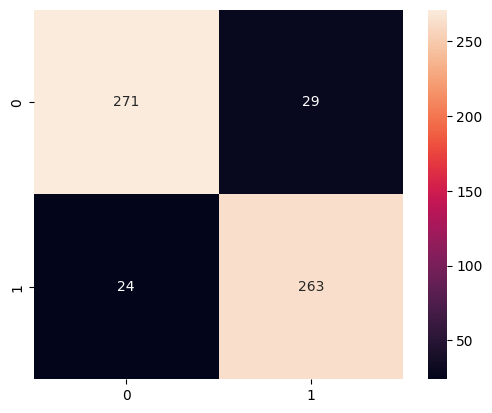

In [ ]:
mat = confusion_matrix(test_data_naive_bayes.label,nb_predictions)
sns.heatmap(mat.T,square = True, annot=True, fmt = 'd')

In [ ]:
accuracy_score(test_data_naive_bayes.label,nb_predictions)


0.909710391822828

In [ ]:
nb_test_precision,nb_test_recall,nb_test_fscore,nb_test_support = precision_recall_fscore_support(test_data_naive_bayes.label,nb_predictions, average='binary')

In [ ]:
print(nb_test_precision)
print(nb_test_recall)
print(nb_test_fscore)

0.9163763066202091
0.9006849315068494
0.9084628670120899


In [ ]:
validation_naive_bayes = pd.read_csv("/content/gdrive/MyDrive/analysis_data/golden_label_downplaying_500.csv", sep=";", encoding = "iso-8859-1")

validation_naive_bayes_filtered = validation_naive_bayes[['downplaying_human_labelled','cleaned_text']]

validation_naive_bayes_filtered.rename(columns={'downplaying_human_labelled' : 'label', 'cleaned_text' : 'sentence'}, inplace = True)

<ipython-input-23-70cfb05a135a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_naive_bayes_filtered.rename(columns={'downplaying_human_labelled' : 'label', 'cleaned_text' : 'sentence'}, inplace = True)


In [ ]:
nb_validation_predictions = nb_model.predict(validation_naive_bayes_filtered.sentence)

<Axes: >

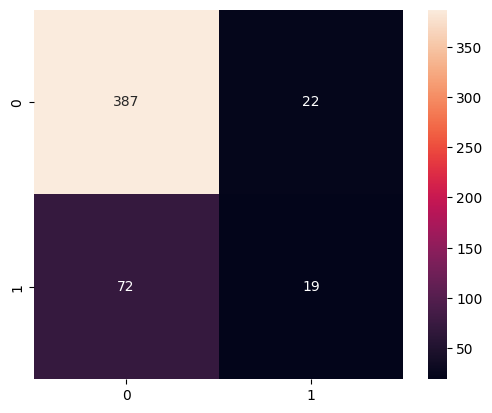

In [ ]:
mat = confusion_matrix(validation_naive_bayes_filtered.label,nb_validation_predictions)
sns.heatmap(mat.T,square = True, annot=True, fmt = 'd')

In [ ]:
accuracy_score(validation_naive_bayes_filtered.label,nb_validation_predictions)

0.812

In [ ]:
precision_recall_fscore_support(validation_naive_bayes_filtered.label,nb_validation_predictions, average='binary')

(0.2087912087912088, 0.4634146341463415, 0.2878787878787879, None)

# Training the fossilBERT model

In [ ]:
del model
del tokenizer

In [ ]:
model_checkpoint = "climatebert/distilroberta-base-climate-f"


model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                           num_labels=2)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at climatebert/distilroberta-base-climate-f were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.de

In [ ]:

def tokenize_function_fossilBERT(examples):
    return tokenizer(examples["cleaned_text"], 
                        add_special_tokens = True,
                        max_length = 256,
                        padding="max_length", 
                        return_attention_mask = True,
                        truncation=True,
                        return_tensors = 'pt'
                        )
    

def tokenize_function_fossilBERT_alternative(examples):
    return tokenizer(examples["sentence"], 
                        add_special_tokens = True,
                        max_length = 256,
                        padding="max_length", 
                        return_attention_mask = True,
                        truncation=True,
                        return_tensors = 'pt'
                        )

# ------------------------------------------------------------------------------
# training arguments
seed_number = 1999
output_directory_name = "./fossilBERT_output"


batch_size = 32

# to chose best performing model
metric_name = 'f1'



args = TrainingArguments(
    output_dir = output_directory_name,
    seed = seed_number,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",  # to decide when the model is saved
    learning_rate = 5e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 4,
    weight_decay = 0.01,
    load_best_model_at_end=True,
    metric_for_best_model = metric_name,
    push_to_hub = False,
    report_to="wandb",
)


# ------------------------------------------------------------------------------
# compute_metrics function



def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# golden_labels_downplaying_dataset_politicians = data_politicians_filtered[data_politicians_filtered['climate_related_pred'] == 1].sample(500)
# golden_labels_downplaying_dataset_politicians['downplaying_human_labelled'] = '-'
# golden_labels_downplaying_dataset_politicians.to_csv('/content/gdrive/MyDrive/analysis_data/downplaying_golden_labels.csv')

In [ ]:
golden_politician_tweets_downplaying = pd.read_csv("/content/gdrive/MyDrive/analysis_data/golden_label_downplaying_500.csv", sep=";", encoding = "iso-8859-1")

golden_politician_tweets_downplaying_filtered = golden_politician_tweets_downplaying[['downplaying_human_labelled','cleaned_text']]

golden_politician_tweets_downplaying_filtered.rename(columns={'downplaying_human_labelled' : 'label', 'cleaned_text' : 'sentence'}, inplace = True)

dataset_golden_politician_tweets_downplaying_filtered = Dataset.from_pandas(golden_politician_tweets_downplaying_filtered)

# tok_dataset_golden_politician_tweets_downplaying_filtered = dataset_golden_politician_tweets_downplaying_filtered.map(tokenize_function_fossilBERT_alternative,batched = True)

<ipython-input-8-890e31e40f37>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  golden_politician_tweets_downplaying_filtered.rename(columns={'downplaying_human_labelled' : 'label', 'cleaned_text' : 'sentence'}, inplace = True)


In [ ]:
# reloading already infered from checkpoint

data_politicians_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_for_analysis_dataset_filtered_inference.csv')

exxon_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/exxon_data_infered.csv')
ipcc_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/ipcc_data_infered.csv')
downplaying_tweets_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/downplaying_tweets_data_infered.csv')
underscoring_tweets_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/underscoring_tweets_data_infered.csv')

greenpeace_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/greenpeace_data_infered.csv')
greenpeace_API_tweet_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/greenpeace_API_tweets_data_infered.csv')






<ipython-input-12-6732e18d5aaa>:3: DtypeWarning: Columns (0,1,9,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data_politicians_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_for_analysis_dataset_filtered_inference.csv')


In [ ]:
climate_influencers = pd.read_parquet('/content/gdrive/MyDrive/analysis_data/inference/climate_influencers_manual_labelled_training.parquet')

In [ ]:
politicians_with_trump = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_with_trump_infered.csv')

<ipython-input-13-0c1e2f736e3a>:1: DtypeWarning: Columns (6,10,13,14,15,16,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  politicians_with_trump = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_with_trump_infered.csv')


In [ ]:
milloy_tweets_climate_related = politicians_with_trump[(politicians_with_trump['author.name'] == 'Steve Milloy') & (politicians_with_trump['climate_related_pred'] == 1)]
milloy_tweets_climate_related['downplaying'] = 1
greenpeace_tweets_climate_related = greenpeace_API_tweet_data_filtered[(greenpeace_API_tweet_data_filtered['author.name'] == 'Greenpeace USA') & (greenpeace_API_tweet_data_filtered['climate_related_pred'] == 1)]

<ipython-input-14-81dfb6e57646>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milloy_tweets_climate_related['downplaying'] = 1


In [ ]:
milloy_greenpeace_tweets_climate_related = pd.concat((milloy_tweets_climate_related.sample(8500),greenpeace_tweets_climate_related)) # test with sampling

In [ ]:
climate_influencers['name_column'].unique()

array(['Steve Milloy', 'George Monbiot', 'Tony Heller', 'Bjorn Lomborg',
       'Mike Hudema', 'American Petroleum Institute', 'Greenpeace USA'],
      dtype=object)

In [ ]:

filter_ipcc = [ "1995_IPCC_SR_AR2_Summary_Policymakers.pdf",
                #"2001_IPCC_SR_AR3_Total_Summary_Policymakers.pdf",
                "2001_IPCC_SR_AR3_wg1_Summary_Policymakers.pdf",
                "2001_IPCC_SR_AR3_wg2_Summary_Policymakers.pdf",
                #"2001_IPCC_SR_AR3_wg3_Summary_Policymakers.pdf",
                "2007_IPCC_SR_AR4_Summary_Policymakers.pdf",
                "2014_IPCC_SR_AR5_Headlines.pdf",
                "2014_IPCC_SR_AR5_Summary_Policymakers.pdf",
                #"2022_IPCC_SR_AR6_WGIII_Headlines.pdf",
                #"2022_IPCC_SR_AR6_WGIII_Summary_Policymakers.pdf",
                "2022_IPCC_SR_AR6_WGII_Headlines.pdf",
                "2022_IPCC_SR_AR6_WGII_Summary_Policymakers.pdf"
                ]

In [ ]:
ipcc_data_filtered = ipcc_data_filtered[ipcc_data_filtered['source'].isin(filter_ipcc)]

In [ ]:
exxon_data_only_climate = exxon_data_filtered[exxon_data_filtered['climate_related_pred'] == 1]
exxon_data_only_climate['from'] = 'exxon'

ipcc_data_filtered_only_climate = ipcc_data_filtered[ipcc_data_filtered['climate_related_pred'] == 1]
ipcc_data_filtered_only_climate['from'] = 'ipcc'

downplaying_tweets_data_filtered_only_climate = downplaying_tweets_data_filtered[downplaying_tweets_data_filtered['climate_related_pred'] == 1]
downplaying_tweets_data_filtered_only_climate['from'] = 'downplaying tweets'

underscoring_tweets_data_filtered_only_climate =underscoring_tweets_data_filtered[underscoring_tweets_data_filtered['climate_related_pred'] == 1]
underscoring_tweets_data_filtered_only_climate['from'] = 'underscoring tweets'

greenpeace_data_filtered_only_climate = greenpeace_data_filtered[greenpeace_data_filtered['climate_related_pred'] == 1]
greenpeace_data_filtered_only_climate['from'] = 'greenpeace'

In [ ]:
fossilbert_data_no_tweets = pd.concat([exxon_data_only_climate,greenpeace_data_filtered_only_climate], ignore_index=True)[['cleaned_text','downplaying','from']]
fossilbert_data_no_tweets.reset_index(drop=True, inplace=True)

In [ ]:
#fossilbert_data_with_tweets = pd.concat([exxon_data_only_climate,ipcc_data_filtered_only_climate, underscoring_tweets_data_filtered_only_climate.sample(7500), downplaying_tweets_data_filtered_only_climate.sample(7500)], ignore_index=True)[['cleaned_text','downplaying']]
#fossilbert_data_with_tweets.reset_index(drop=True, inplace=True)
#fossilbert_data_with_tweets['downplaying'] = pd.to_numeric(fossilbert_data_with_tweets['downplaying'])

In [ ]:
# case for Greenpeace vs. API)
fossilbert_data_only_tweets = greenpeace_API_tweet_data_filtered[greenpeace_API_tweet_data_filtered['climate_related_pred']==1][['cleaned_text','downplaying','author.name']]
fossilbert_data_only_tweets['downplaying'] = pd.to_numeric(fossilbert_data_only_tweets['downplaying'])

In [ ]:
# case for Greenpeace vs. Milloy
fossilbert_data_only_tweets = milloy_greenpeace_tweets_climate_related[milloy_greenpeace_tweets_climate_related['climate_related_pred']==1][['cleaned_text','downplaying','author.name']]
fossilbert_data_only_tweets['downplaying'] = pd.to_numeric(fossilbert_data_only_tweets['downplaying'])

In [ ]:
fossilbert_data_only_tweets.sample(5)

,cleaned_text,downplaying,author.name
47158,In case you missed it: This week GreenpeaceUK ...,0,Greenpeace USA
58481,Will George from the Tseil Waututh Nation join...,0,Greenpeace USA
92233,George Will: 'Global warming is socialism by t...,1,Steve Milloy
55999,Food and agricultural production accounts for ...,0,Greenpeace USA
50631,Imbeciles at French Climate Action Network (RA...,1,Steve Milloy


In [ ]:
sum(fossilbert_data_only_tweets['downplaying'] == 1)/len(fossilbert_data_only_tweets['downplaying'])

0.4960028009569936

In [ ]:
#fossilbert_data_no_tweets.rename(columns={'downplaying' : 'label'}, inplace = True)
#fossilbert_data_no_tweets['label'] = pd.to_numeric(fossilbert_data_no_tweets['label'])

#fossilbert_data_no_tweets_training, fossilbert_data_no_tweets_validation = train_test_split(fossilbert_data_no_tweets, test_size = 0.2, stratify = fossilbert_data_no_tweets['label'])

#dataset_fossilbert_data_no_tweets_training = Dataset.from_pandas(fossilbert_data_no_tweets_training)
#dataset_fossilbert_data_no_tweets_validation = Dataset.from_pandas(fossilbert_data_no_tweets_validation)

In [ ]:
#fossilbert_data_with_tweets.rename(columns={'downplaying' : 'label'}, inplace = True)
#fossilbert_data_with_tweets['label'] = pd.to_numeric(fossilbert_data_with_tweets['label'])

#fossilbert_data_with_tweets_training, fossilbert_data_with_tweets_validation = train_test_split(fossilbert_data_with_tweets, test_size = 0.2, stratify = fossilbert_data_with_tweets['label'])

#dataset_fossilbert_data_with_tweets_training = Dataset.from_pandas(fossilbert_data_with_tweets_training)
#dataset_fossilbert_data_with_tweets_validation = Dataset.from_pandas(fossilbert_data_with_tweets_validation)


In [ ]:
fossilbert_data_only_tweets.rename(columns={'downplaying' : 'label'}, inplace = True)
fossilbert_data_only_tweets['label'] = pd.to_numeric(fossilbert_data_only_tweets['label'])

fossilbert_data_only_tweets_training, fossilbert_data_only_tweets_validation = train_test_split(fossilbert_data_only_tweets, test_size = 0.2, stratify = fossilbert_data_only_tweets['label'])

dataset_fossilbert_data_only_tweets_training = Dataset.from_pandas(fossilbert_data_only_tweets_training)
dataset_fossilbert_data_only_tweets_validation = Dataset.from_pandas(fossilbert_data_only_tweets_validation)

In [ ]:
climate_influencers.rename(columns={'downplaying_column' : 'label'}, inplace = True)
climate_influencers['label'] = pd.to_numeric(climate_influencers['label'])

climate_influencers_training, climate_influencers_validation = train_test_split(climate_influencers, test_size = 0.2, stratify = climate_influencers['label'])

dataset_climate_influencers_training = Dataset.from_pandas(climate_influencers_training)
dataset_climate_influencers_validation = Dataset.from_pandas(climate_influencers_validation)

training without tweets

In [ ]:
# tokenizing the datasets:

tok_dataset_fossilbert_data_no_tweets_training = dataset_fossilbert_data_no_tweets_training.map(tokenize_function_fossilBERT, batched = True)
tok_dataset_fossilbert_data_no_tweets_validation = dataset_fossilbert_data_no_tweets_validation.map(tokenize_function_fossilBERT, batched = True)


In [ ]:

#tok_dataset_fossilbert_data_with_tweets_training = dataset_fossilbert_data_with_tweets_training.map(tokenize_function_fossilBERT, batched = True)
#tok_dataset_fossilbert_data_with_tweets_validation = dataset_fossilbert_data_with_tweets_validation.map(tokenize_function_fossilBERT, batched = True)

In [ ]:
tok_dataset_fossilbert_data_only_tweets_training = dataset_fossilbert_data_only_tweets_training.map(tokenize_function_fossilBERT, batched = True)
tok_dataset_fossilbert_data_only_tweets_validation = dataset_fossilbert_data_only_tweets_validation.map(tokenize_function_fossilBERT, batched = True)

Map:   0%|          | 0/13709 [00:00<?, ? examples/s]

Map:   0%|          | 0/3428 [00:00<?, ? examples/s]

In [ ]:
tok_dataset_climate_influencers_training = dataset_climate_influencers_training.map(tokenize_function_fossilBERT, batched = True)
tok_dataset_climate_influencers_validation = dataset_climate_influencers_validation.map(tokenize_function_fossilBERT, batched = True)

Map:   0%|          | 0/2346 [00:00<?, ? examples/s]

Map:   0%|          | 0/587 [00:00<?, ? examples/s]

In [ ]:
#tok_golden_downplaying = dataset_golden_politician_tweets_downplaying.map(tokenize_function_fossilBERT, batched = True)

In [ ]:
# tok_dataset_fossilbert_data_no_tweets_training.remove_columns(dataset_fossilbert_data_no_tweets_training.column_names)
# tok_dataset_fossilbert_data_no_tweets_validation.remove_columns(dataset_fossilbert_data_no_tweets_validation.column_names)

In [ ]:
directory_to_save_fossilBERT_to = "./fossilBERT_climateBERT/run3"


trainer_fossilBERT = Trainer(
    model,
    args,
    train_dataset = tok_dataset_climate_influencers_training,
    eval_dataset = tok_dataset_climate_influencers_validation,
    tokenizer = tokenizer,
    
    compute_metrics = compute_metrics ##,
    ## optimizer = ""
)

In [ ]:
# initialize wandb monitoring under project file name
wandb.init(project = "fossilBERT_climate_influencers"
           )

trainer_fossilBERT.train()

# terminate the monitoring
wandb.finish()

trainer_fossilBERT.save_model(directory_to_save_fossilBERT_to)





/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.237606,0.904600,0.902778,0.915493,0.890411
2,No log,0.228615,0.926746,0.927731,0.910891,0.945205
3,No log,0.274338,0.926746,0.925734,0.933798,0.917808
4,No log,0.328800,0.926746,0.927242,0.916388,0.938356


eval/accuracy,▁███
eval/f1,▁█▇█
eval/loss,▂▁▄█
eval/precision,▂▁█▃
eval/recall,▁█▅▇
eval/runtime,▂██▁
eval/samples_per_second,▇▁▁█
eval/steps_per_second,▇▁▁█
train/epoch,▁▃▆██
train/global_step,▁▃▆██
train/total_flos,▁


In [ ]:
# fossilBERT_no_tweets_pipe = pipeline("text-classification", model = directory_to_save_fossilBERT_to, tokenizer = model_checkpoint, device=0)

In [ ]:
fossilBERT_no_tweets_pipe = pipeline("text-classification", model = "/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_roBERTa_base", tokenizer = "roberta-base", device=0)


In [ ]:
fossilBERT_no_tweets_pipe("'Global warming is socialism by the back door' And 'socialism' is a EUPHEMISM for TOTALITARIANISM.")

[{'label': 'LABEL_1', 'score': 0.9999620914459229}]

In [ ]:
dataset_politicians_filtered = Dataset.from_pandas(data_politicians_filtered[data_politicians_filtered['climate_related_pred']==1][['cleaned_text','party']])

In [ ]:
data_politicians_filtered_test = data_politicians_filtered[data_politicians_filtered['climate_related_pred']==1]
data_politicians_filtered_test.reset_index(drop = True, inplace = True)

In [ ]:
predictions_politicians_downplaying = fossilBERT_no_tweets_pipe(dataset_politicians_filtered['cleaned_text'], batch_size = 32)

In [ ]:
data_politicians_filtered_test['downplaying_infered'] = predictions_politicians_downplaying

<ipython-input-88-8699f9c364c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_politicians_filtered_test['downplaying_infered'] = predictions_politicians_downplaying


In [ ]:
data_politicians_filtered_test['downplaying_pred'] = 0

for i in range(len(data_politicians_filtered_test)):
  
  label_pred = data_politicians_filtered_test['downplaying_infered'][i]['label']
  if label_pred == 'LABEL_0':
    output_pred = 0
  else:
    output_pred = 1

  data_politicians_filtered_test['downplaying_pred'][i] = output_pred

In [ ]:
data_politicians_filtered_test[data_politicians_filtered_test['downplaying_pred'] == 0].sample(50)

In [ ]:
fossilBERT_no_tweets_pipe = pipeline("text-classification", model = "/content/fossilBERT_climateBERT/run", tokenizer = model_checkpoint, device=0) # change tokenizer for BERT underlying model

metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

task_evaluator_fossilBERT_no_tweets = evaluator("text-classification")

results_first_run = task_evaluator_fossilBERT_no_tweets.compute(model_or_pipeline=fossilBERT_no_tweets_pipe, 
                                                      data=dataset_golden_politician_tweets_downplaying_filtered, # add golden label dataset
                                                      metric=metric,
                                                      input_column="sentence",
                                                      label_column="label",
                                                      label_mapping={"LABEL_0": 0, "LABEL_1": 1}#, # needs to be changed depending on the model
                                                      #strategy="bootstrap",
                                                      #n_resamples=3
                                                     )

print(results_first_run)

{'accuracy': 0.134, 'f1': 0.15264187866927592, 'precision': 0.08297872340425531, 'recall': 0.9512195121951219, 'total_time_in_seconds': 3.497717308999654, 'samples_per_second': 142.95037472396527, 'latency_in_seconds': 0.006995434617999309}


In [ ]:
results_first_run

{'accuracy': {'confidence_interval': (0.7821380498166873, 0.8351817563144278),
  'standard_error': 0.03019933774108297,
  'score': 0.812},
 'f1': {'confidence_interval': (nan, nan),
  'standard_error': 0.04647771951458026,
  'score': 0.30882352941176466},
 'precision': {'confidence_interval': (0.18310373641989422,
   0.29927906281798505),
  'standard_error': 0.0718303377897864,
  'score': 0.22105263157894736},
 'recall': {'confidence_interval': (nan, nan),
  'standard_error': 0.03856561238908007,
  'score': 0.5121951219512195},
 'total_time_in_seconds': 3.4292552799997793,
 'samples_per_second': 145.80425170331216,
 'latency_in_seconds': 0.006858510559999558}

In [ ]:
# source: https://huggingface.co/docs/evaluate/base_evaluator

models = [
    "/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_climateBERT",
    "/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_API_climateBERT/run",
    "/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_API_BERTweet",
    "/content/gdrive/MyDrive/fossilBERT/fossilBERT_no_tweets_greenpeace_exxon_climateBERT",
    "/content/gdrive/MyDrive/fossilBERT/fossilBERT_no_tweets_greenpeace_exxon_BERT",
    "/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_climateBERT_claims",
    "/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_BERT",
    "/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_roBERTa_base",
    "/content/gdrive/MyDrive/fossilBERT/fossilBERT_climate_influencers_climateBERT"
]

metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

data = dataset_golden_politician_tweets_downplaying_filtered
task_evaluator = evaluator("text-classification")

results = []
for model in models:
  # using BERT as the underlying model requires the tokenizer to be set manually (otherwise some masks do not have the correct ID)
  if model in ["/content/gdrive/MyDrive/fossilBERT/fossilBERT_no_tweets_greenpeace_exxon_BERT","/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_BERT"]:
    results.append(
        task_evaluator.compute(
            model_or_pipeline=model,
            tokenizer = "bert-base-uncased", # using the original BERT base tokenizer
            data=data, 
            metric=metric,
            input_column="sentence",
            label_column="label",
            label_mapping={"LABEL_0": 0, "LABEL_1": 1}
            )
        )

  # using roBERTa as the underlying introduces the same problem as above
  elif model == "/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_roBERTa_base":
    results.append(
        task_evaluator.compute(
            model_or_pipeline=model,
            tokenizer = "roberta-base", # using the original roberta base tokenizer
            data=data, 
            metric=metric,
            input_column="sentence",
            label_column="label",
            label_mapping={"LABEL_0": 0, "LABEL_1": 1}
            )
        )

  # the climateBERT pretrained on claims requires the label mapping to be "yes/no" instead of "LABEL_1/LABEL_0" as in the other models
  elif model == "/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_climateBERT_claims":
    results.append(
        task_evaluator.compute(
            model_or_pipeline=model,
            data=data, 
            metric=metric,
            input_column="sentence",
            label_column="label",
            label_mapping={"no": 0, "yes": 1} # using a slightly different mapping where no = 0, and yes = 1
            )
        )

  # for all other "normal" models
  else:
    results.append(
        task_evaluator.compute(
            model_or_pipeline=model, 
            data=data, 
            metric=metric,
            input_column="sentence",
            label_column="label",
            label_mapping={"LABEL_0": 0, "LABEL_1": 1}
            )
        )


df = pd.DataFrame(results, index=models)



emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [ ]:
df.sort_values(by = ['f1'], ascending = False)

,accuracy,f1,precision,recall,total_time_in_seconds,samples_per_second,latency_in_seconds
/content/gdrive/MyDrive/fossilBERT/fossilBERT_climate_influencers_climateBERT,0.844,0.380952,0.282353,0.585366,3.343831,149.529086,0.006688
/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_climateBERT,0.876,0.326087,0.294118,0.365854,6.847206,73.022490,0.013694
/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_BERT,0.856,0.320755,0.261538,0.414634,5.764217,86.742053,0.011528
/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_roBERTa_base,0.888,0.317073,0.317073,0.317073,5.845123,85.541395,0.011690
/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_API_climateBERT/run,0.824,0.214286,0.169014,0.292683,3.382199,147.832821,0.006764
/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_milloy_climateBERT_claims,0.862,0.188235,0.181818,0.195122,3.332369,150.043398,0.006665
/content/gdrive/MyDrive/fossilBERT/fossilBERT_only_tweets_greenpeace_API_BERTweet,0.742,0.097902,0.068627,0.170732,6.094322,82.043581,0.012189
/content/gdrive/MyDrive/fossilBERT/fossilBERT_no_tweets_greenpeace_exxon_climateBERT,0.856,0.000000,0.000000,0.000000,3.409913,146.631319,0.006820
/content/gdrive/MyDrive/fossilBERT/fossilBERT_no_tweets_greenpeace_exxon_BERT,0.874,0.000000,0.000000,0.000000,5.707529,87.603583,0.011415


In [ ]:
df.to_csv("/content/gdrive/MyDrive/analysis_data/model_comparison_table.csv")

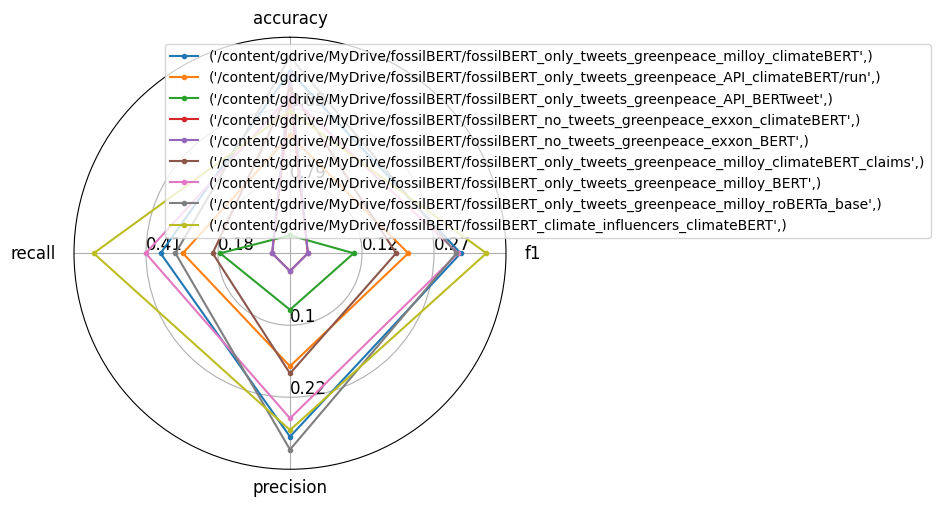

In [ ]:
import evaluate
from evaluate.visualization import radar_plot

plot = radar_plot(data=df[['accuracy','f1','precision','recall']], model_names=models, )
plot.show()

In [ ]:
# !cp -r "/content/fossilBERT_climateBERT/run" /content/gdrive/MyDrive/fossilBERT/fossilBERT_climate_influencers_climateBERT

In [ ]:
# second run

directory_to_save_second_fossilBERT_to = "./fossilBERT_climateBERT_second/run"


fossilBERT_model_second_run = AutoModelForSequenceClassification.from_pretrained(directory_to_save_fossilBERT_to)
fossilBERT_tokenizer_second_run = AutoTokenizer.from_pretrained(directory_to_save_fossilBERT_to)


trainer_fossilBERT_second_run = Trainer(
    fossilBERT_model_second_run,
    args,
    train_dataset = tok_dataset_fossilbert_data_no_tweets_training,
    eval_dataset = tok_dataset_fossilbert_data_no_tweets_validation,
    tokenizer = fossilBERT_tokenizer_second_run,
    compute_metrics = compute_metrics ##,
    ## optimizer = ""
)


wandb.init(project = "fossilBERT_second_run")

trainer_fossilBERT_second_run.train()

wandb.finish()

trainer_fossilBERT_second_run.save_model(directory_to_save_second_fossilBERT_to)



loading configuration file ./fossilBERT_climateBERT/run/config.json
Model config RobertaConfig {
  "_name_or_path": "./fossilBERT_climateBERT/run",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50500
}

loading weights file ./fossilBERT_climateBERT/run/pytorch_model.bin
All model checkpoint weights were used when initial

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: cleaned_text, __index_level_0__, from. If cleaned_text, __index_level_0__, from are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 848
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 135
  Number of trainable parameters = 82300418
Automatic Weights & Biases logging enabled, to disable set os.environ["

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.264599,0.901408,0.901408,0.914286,0.888889
2,No log,0.278499,0.901408,0.893401,0.988764,0.814815
3,No log,0.105015,0.971831,0.972222,0.972222,0.972222
4,No log,0.097698,0.971831,0.972222,0.972222,0.972222
5,No log,0.088238,0.976526,0.976959,0.972477,0.981481


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: cleaned_text, __index_level_0__, from. If cleaned_text, __index_level_0__, from are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 213
  Batch size = 32
Saving model checkpoint to ./fossilBERT_output/checkpoint-27
Configuration saved in ./fossilBERT_output/checkpoint-27/config.json
Model weights saved in ./fossilBERT_output/checkpoint-27/pytorch_model.bin
tokenizer config file saved in ./fossilBERT_output/checkpoint-27/tokenizer_config.json
Special tokens file saved in ./fossilBERT_output/checkpoint-27/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: cleaned_text, __index_level_0__, from. If cleaned_text, __index_level_0_

eval/accuracy,▁▁███
eval/f1,▂▁███
eval/loss,▇█▂▁▁
eval/precision,▁█▆▆▆
eval/recall,▄▁███
eval/runtime,▁█▇▁▁
eval/samples_per_second,█▁▁██
eval/steps_per_second,█▁▁██
train/epoch,▁▃▅▆██
train/global_step,▁▃▅▆██
train/total_flos,▁


Saving model checkpoint to ./fossilBERT_climateBERT_second/run
Configuration saved in ./fossilBERT_climateBERT_second/run/config.json
Model weights saved in ./fossilBERT_climateBERT_second/run/pytorch_model.bin
tokenizer config file saved in ./fossilBERT_climateBERT_second/run/tokenizer_config.json
Special tokens file saved in ./fossilBERT_climateBERT_second/run/special_tokens_map.json


In [ ]:
fossilBERT_pipe_second_run = pipeline("text-classification", model = directory_to_save_second_fossilBERT_to, device=0)

task_evaluator_second_run = evaluator("text-classification")
results_second_run = task_evaluator_second_run.compute(model_or_pipeline=fossilBERT_pipe_second_run, 
                                                        data=dataset_golden_politician_tweets_downplaying_filtered, 
                                                        metric=metric,
                                                        input_column="sentence",
                                                        label_column="label",
                                                        label_mapping={"LABEL_0": 0, "LABEL_1": 1}#,
                                                        #strategy="bootstrap",
                                                        #n_resamples=10
                                                       )



print(results_second_run)

loading configuration file ./fossilBERT_climateBERT_second/run/config.json
Model config RobertaConfig {
  "_name_or_path": "./fossilBERT_climateBERT_second/run",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50500
}

loading configuration file ./fossilBERT_climateBERT_second/run/config.json
Model config RobertaConfig {
 

{'accuracy': 0.776, 'f1': 0.08196721311475409, 'precision': 0.06172839506172839, 'recall': 0.12195121951219512, 'total_time_in_seconds': 3.766231338999887, 'samples_per_second': 132.75870624898303, 'latency_in_seconds': 0.007532462677999774}


In [ ]:
#!cp -r '/content/fossilBERT_output/checkpoint-6290' /content/gdrive/MyDrive/fossilBERT_climateBERT_with_tweets/

In [ ]:
!cp -r '/content/fossilBERT_output/checkpoint-6290' /content/gdrive/MyDrive/fossilBERT_climateBERT_with_tweets/

In [ ]:
underscoring_tweets_data_filtered_only_climate.sample(5)

In [ ]:
fossilBERT_no_tweets_pipe("At World People's Conf. on Climate Change, UN chief Ban says climatechange is moral issue	")

[{'label': 'LABEL_0', 'score': 0.9999970197677612}]

In [ ]:
predictions_golden_dataset_tweets = fossilBERT_no_tweets_pipe(dataset_golden_politician_tweets_downplaying['sentence'], batch_size = 32)

In [ ]:
golden_politician_tweets_downplaying['preds'] = predictions_golden_dataset_tweets

In [ ]:
golden_politician_tweets_downplaying.sample(100)

# Inference of downplaying on other data

setup the inference pipeline

In [ ]:
downplaying_pipe_fossilBERT = pipeline("text-classification", model = "/content/gdrive/MyDrive/fossilBERT/fossilBERT_climate_influencers_climateBERT", device=0)

Golden Label Dataset

In [ ]:
golden_politician_tweets_downplaying_filtered.rename(columns = {"label":"true_label"}, inplace = True)

<ipython-input-33-a891d6a6a58e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  golden_politician_tweets_downplaying_filtered.rename(columns = {"label":"true_label"}, inplace = True)


In [ ]:
golden_politician_tweets_downplaying_filtered.head(2)

,true_label,sentence,full_prediction_downplaying,downplaying_pred
0,0,"RepLipinski [...] carbon capture and reuse, en...","{'label': 'LABEL_0', 'score': 0.9980292916297913}",0
1,0,"The NCA4, a report by 13 federal agencies incl...","{'label': 'LABEL_0', 'score': 0.9997652173042297}",0


In [ ]:
predictions_golden_labels = downplaying_pipe_fossilBERT(dataset_golden_politician_tweets_downplaying_filtered['sentence'], batch_size = 32)
golden_politician_tweets_downplaying_filtered['full_prediction_downplaying'] = predictions_golden_labels

golden_politician_tweets_downplaying_filtered['downplaying_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in golden_politician_tweets_downplaying_filtered['full_prediction_downplaying']]

mat = confusion_matrix(golden_politician_tweets_downplaying_filtered.true_label,golden_politician_tweets_downplaying_filtered.downplaying_pred)
sns.heatmap(mat.T,square = True, annot=True, fmt = 'd')

<Axes: >

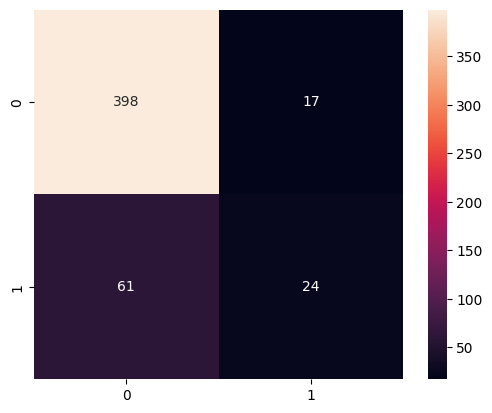

politicians (second run)

In [ ]:
data_politicians_second_predictions = pd.read_parquet('/content/gdrive/MyDrive/analysis_data/final_inference/politicians_final_infered.parquet')

data_politicians_second_predictions_only_climate = data_politicians_second_predictions[data_politicians_second_predictions['climate_related_pred'] == 1]
data_politicians_second_predictions_only_climate.reset_index(drop = True, inplace = True)

dataset_politicians_second_predictions_only_climate = Dataset.from_pandas(data_politicians_second_predictions_only_climate)

predictions_downplaying_politicians_second_run = downplaying_pipe_fossilBERT(dataset_politicians_second_predictions_only_climate['cleaned_text'], batch_size = 32)
data_politicians_second_predictions_only_climate['full_prediction_downplaying'] = predictions_downplaying_politicians_second_run

data_politicians_second_predictions_only_climate['downplaying_pred_second_run'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_politicians_second_predictions_only_climate['full_prediction_downplaying']]
final_second_run_politicians_predictions =  data_politicians_second_predictions.merge(data_politicians_second_predictions_only_climate[['id','downplaying_pred_second_run']],how = 'left',  on = 'id')
final_second_run_politicians_predictions['downplaying_pred_second_run'] = final_second_run_politicians_predictions['downplaying_pred_second_run'].fillna(0)

In [ ]:
final_second_run_politicians_predictions.to_parquet("/content/gdrive/MyDrive/analysis_data/climate_influencer_inference/us_politicians_infered.parquet")

politicians with trump

In [ ]:
data_politicians_with_trump_infered_climate = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_with_trump_infered.csv')
data_politicians_with_trump_infered_climate.rename(columns={'predictions' : 'full_prediction_climate'}, inplace = True)

data_politicians_with_trump_infered_climate_only_climate = data_politicians_with_trump_infered_climate[data_politicians_with_trump_infered_climate['climate_related_pred'] == 1]
data_politicians_with_trump_infered_climate_only_climate.reset_index(drop = True, inplace = True)

dataset_politicians_with_trump_infered_climate_only_climate = Dataset.from_pandas(data_politicians_with_trump_infered_climate_only_climate)

predictions_downplaying_politicians_with_trump = downplaying_pipe_fossilBERT(dataset_politicians_with_trump_infered_climate_only_climate['cleaned_text'], batch_size = 32)
data_politicians_with_trump_infered_climate_only_climate['full_prediction_downplaying'] = predictions_downplaying_politicians_with_trump

data_politicians_with_trump_infered_climate_only_climate['downplaying_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_politicians_with_trump_infered_climate_only_climate['full_prediction_downplaying']]

final_politicians_with_trump_infered = data_politicians_with_trump_infered_climate.merge(data_politicians_with_trump_infered_climate_only_climate[['id','downplaying_pred']],how = 'left',  on = 'id')
final_politicians_with_trump_infered['downplaying_pred'] = final_politicians_with_trump_infered['downplaying_pred'].fillna(0)

In [ ]:
final_politicians_with_trump_infered.to_parquet("/content/gdrive/MyDrive/analysis_data/climate_influencer_inference/tweets_with_trump_infered.parquet")

selected politicians

In [ ]:

data_selected_politicians = pd.read_parquet("/content/gdrive/MyDrive/analysis_data/inference/selected_politicians_data_infered.parquet")
data_selected_politicians.rename(columns={'predictions' : 'full_prediction_climate'}, inplace = True)

data_selected_politicians_only_climate = data_selected_politicians[data_selected_politicians['climate_related_pred'] == 1]
data_selected_politicians_only_climate.reset_index(drop = True, inplace = True)

dataset_selected_politicians = Dataset.from_pandas(data_selected_politicians_only_climate)

predictions_downplaying_selected_politicians = downplaying_pipe_fossilBERT(dataset_selected_politicians['cleaned_text'], batch_size = 32)
data_selected_politicians_only_climate['full_prediction_downplaying'] = predictions_downplaying_selected_politicians

data_selected_politicians_only_climate['downplaying_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_selected_politicians_only_climate['full_prediction_downplaying']]

final_selected_politicians_infered = data_selected_politicians.merge(data_selected_politicians_only_climate[['id','downplaying_pred']],how = 'left',  on = 'id')
final_selected_politicians_infered['downplaying_pred'] = final_selected_politicians_infered['downplaying_pred'].fillna(0)

<ipython-input-21-a9d36446b3b1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected_politicians_only_climate['full_prediction_downplaying'] = predictions_downplaying_selected_politicians
<ipython-input-21-a9d36446b3b1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected_politicians_only_climate['downplaying_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_selected_politicians_only_climate['full_prediction_downplaying']]


In [ ]:
final_selected_politicians_infered.to_parquet("/content/gdrive/MyDrive/analysis_data/climate_influencer_inference/selected_politicians_infered.parquet")

UK

In [ ]:
data_politicians_uk_infered_climate = pd.read_parquet('/content/gdrive/MyDrive/analysis_data/inference/politicians_uk_infered.parquet')
data_politicians_uk_infered_climate.rename(columns={'predictions' : 'full_prediction_climate'}, inplace = True)

data_politicians_uk_infered_climate_only_climate = data_politicians_uk_infered_climate[data_politicians_uk_infered_climate['climate_related_pred'] == 1]
data_politicians_uk_infered_climate_only_climate.reset_index(drop = True, inplace = True)

dataset_politicians_uk_infered_climate_only_climate = Dataset.from_pandas(data_politicians_uk_infered_climate_only_climate)

predictions_downplaying_politicians_uk = downplaying_pipe_fossilBERT(dataset_politicians_uk_infered_climate_only_climate['cleaned_text'], batch_size = 32)
data_politicians_uk_infered_climate_only_climate['full_prediction_downplaying'] = predictions_downplaying_politicians_uk
data_politicians_uk_infered_climate_only_climate['downplaying_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_politicians_uk_infered_climate_only_climate['full_prediction_downplaying']]

final_politicians_uk_predictions =  data_politicians_uk_infered_climate.merge(data_politicians_uk_infered_climate_only_climate[['id','downplaying_pred']],how = 'left',  on = 'id')
final_politicians_uk_predictions['downplaying_pred'] = final_politicians_uk_predictions['downplaying_pred'].fillna(0)


In [ ]:
final_politicians_uk_predictions.to_parquet("/content/gdrive/MyDrive/analysis_data/climate_influencer_inference/uk_politicians_infered.parquet")

Australia

In [ ]:
data_politicians_australia_infered_climate = pd.read_parquet('/content/gdrive/MyDrive/analysis_data/inference/politicians_australia_infered.parquet')
data_politicians_australia_infered_climate.rename(columns={'predictions' : 'full_prediction_climate'}, inplace = True)

data_politicians_australia_infered_climate_only_climate = data_politicians_australia_infered_climate[data_politicians_australia_infered_climate['climate_related_pred'] == 1]
data_politicians_australia_infered_climate_only_climate.reset_index(drop = True, inplace = True)

dataset_politicians_australia_infered_climate_only_climate = Dataset.from_pandas(data_politicians_australia_infered_climate_only_climate)

predictions_downplaying_politicians_australia = downplaying_pipe_fossilBERT(dataset_politicians_australia_infered_climate_only_climate['cleaned_text'], batch_size = 32)
data_politicians_australia_infered_climate_only_climate['full_prediction_downplaying'] = predictions_downplaying_politicians_australia
data_politicians_australia_infered_climate_only_climate['downplaying_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_politicians_australia_infered_climate_only_climate['full_prediction_downplaying']]

final_politicians_australia_predictions =  data_politicians_australia_infered_climate.merge(data_politicians_australia_infered_climate_only_climate[['id','downplaying_pred']],how = 'left',  on = 'id')
final_politicians_australia_predictions['downplaying_pred'] = final_politicians_australia_predictions['downplaying_pred'].fillna(0)


<ipython-input-74-dd9c55056ae7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_politicians_australia_infered_climate_only_climate['full_prediction_downplaying'] = predictions_downplaying_politicians_australia
<ipython-input-74-dd9c55056ae7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_politicians_australia_infered_climate_only_climate['downplaying_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_politicians_australia_infered_climate_only_climate['full_predictio

In [ ]:
final_politicians_australia_predictions.to_parquet("/content/gdrive/MyDrive/analysis_data/climate_influencer_inference/australian_politicians_infered.parquet")


In [ ]:
#data_politicians_infered_climate = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_with_climate_pred_infered.csv', sep = '§')

# workaround
# data_politicians_infered_climate = data_politicians_with_climate_pred


data_politicians_with_trump_infered_climate = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_with_trump_infered.csv')

data_politicians_uk_infered_climate = pd.read_parquet('/content/gdrive/MyDrive/analysis_data/inference/politicians_uk_infered.parquet')
data_politicians_australia_infered_climate = pd.read_parquet('/content/gdrive/MyDrive/analysis_data/inference/politicians_australia_infered.parquet')

# exxon_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/exxon_data_infered.csv')
# ipcc_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/ipcc_data_infered.csv')
# downplaying_tweets_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/downplaying_tweets_data_infered.csv')
# underscoring_tweets_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/underscoring_tweets_data_infered.csv')

# greenpeace_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/greenpeace_data_infered.csv')
# greenpeace_API_tweet_data_filtered = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/greenpeace_API_tweets_data_infered.csv')

<ipython-input-50-726d8adc0d50>:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  data_politicians_infered_climate = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_with_climate_pred_infered.csv', sep = '§')
<ipython-input-50-726d8adc0d50>:7: DtypeWarning: Columns (6,10,13,14,15,16,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data_politicians_with_trump_infered_climate = pd.read_csv('/content/gdrive/MyDrive/analysis_data/inference/politicians_with_trump_infered.csv')


In [ ]:
# data_politicians_infered_climate_filtered = data_politicians_infered_climate.dropna(subset = 'id').iloc[:,1:].copy()

# data_politicians_infered_climate_filtered['id'] = data_politicians_infered_climate_filtered['id'].astype('int')

In [ ]:
data_politicians_infered_climate_only_climate = data_politicians_infered_climate[data_politicians_infered_climate['climate_related_pred'] == 1]
data_politicians_infered_climate_only_climate.reset_index(drop = True, inplace = True)

In [ ]:
# fossilBERT_pipe_Exxon = pipeline("text-classification", model = "/content/gdrive/MyDrive/fossilBERT/fossilBERT_no_tweets_greenpeace_exxon_climateBERT")

downplaying predictions politicians UK & Australia

predictions second run

In [ ]:
predictions_downplaying_politicians_second_run = downplaying_pipe_fossilBERT(dataset_politicians_second_predictions_only_climate['cleaned_text'], batch_size = 32)
data_politicians_second_predictions_only_climate['full_prediction_downplaying'] = predictions_downplaying_politicians_second_run

<ipython-input-57-3f6900a219ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_politicians_second_predictions_only_climate['full_prediction_downplaying'] = predictions_downplaying_politicians_second_run


In [ ]:
data_politicians_second_predictions_only_climate['downplaying_pred_second_run'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_politicians_second_predictions_only_climate['full_prediction_downplaying']]

<ipython-input-58-4dd8f616ab68>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_politicians_second_predictions_only_climate['downplaying_pred_second_run'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_politicians_second_predictions_only_climate['full_prediction_downplaying']]


In [ ]:
sum(data_politicians_second_predictions_only_climate[data_politicians_second_predictions_only_climate['downplaying_pred_second_run'] == 1]['party'] == 'Republican')

307

In [ ]:
final_second_run_politicians_predictions =  data_politicians_second_predictions.merge(data_politicians_second_predictions_only_climate[['id','downplaying_pred_second_run']],how = 'left',  on = 'id')
final_second_run_politicians_predictions['downplaying_pred_second_run'] = final_second_run_politicians_predictions['downplaying_pred_second_run'].fillna(0)

In [ ]:
sum(final_second_run_politicians_predictions['downplaying_pred_second_run']==1)

566

predictions for smaller dataset (with trump)

predictions for large dataset

In [ ]:
predictions_downplaying_politicians = downplaying_pipe_fossilBERT(dataset_politicians_infered_climate_only_climate['cleaned_text'], batch_size = 32)
data_politicians_infered_climate_only_climate['full_prediction_downplaying'] = predictions_downplaying_politicians

In [ ]:
data_politicians_infered_climate_only_climate['downplaying_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_politicians_infered_climate_only_climate['full_prediction_downplaying']]

<ipython-input-240-24c84a0c3b22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_politicians_infered_climate_only_climate['downplaying_pred'] = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in data_politicians_infered_climate_only_climate['full_prediction_downplaying']]


In [ ]:
final_politicians_infered = data_politicians_infered_climate.merge(data_politicians_infered_climate_only_climate[['id','downplaying_pred']],how = 'left',  on = 'id')
final_politicians_infered['downplaying_pred'] = final_politicians_infered['downplaying_pred'].fillna(0)

save the final dataset for further analysis

In [ ]:
final_politicians_with_trump_infered.to_csv("/content/gdrive/MyDrive/analysis_data/final_inference/politicians_with_trump_final_infered.csv", sep = '§')
final_politicians_with_trump_infered.to_parquet('/content/gdrive/MyDrive/analysis_data/final_inference/politicians_with_trump_final_infered.parquet')

In [ ]:
final_politicians_infered.to_csv("/content/gdrive/MyDrive/analysis_data/final_inference/politicians_final_infered.csv", sep = '§')
final_politicians_infered.to_parquet('/content/gdrive/MyDrive/analysis_data/final_inference/politicians_final_infered.parquet')

In [ ]:
final_second_run_politicians_predictions.to_parquet('/content/gdrive/MyDrive/analysis_data/final_inference/politicians_final_second_infered.parquet')

In [ ]:
final_politicians_uk_predictions.to_parquet('/content/gdrive/MyDrive/analysis_data/final_inference/politicians_uk_final_infered.parquet')
final_politicians_australia_predictions.to_parquet('/content/gdrive/MyDrive/analysis_data/final_inference/politicians_australia_final_infered.parquet')

In [ ]:
milloy_greenpeace_tweets_climate_related.to_csv("/content/gdrive/MyDrive/analysis_data/manual_labelling_milloy.csv")

greenpeace_tweets_climate_related.to_csv("/content/gdrive/MyDrive/analysis_data/manual_labelling_greenpeace.csv")